# Statevector simulator

Quick solution to the exercise of Lecture 2.

## A classical simulator for quantum circuits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tools import Circuit, gate_dic
from state_vector_qpu import State, StateVectorQPU

# a couple of tests
psi = State(2)
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 0, 0]))<1e-13)

psi.apply("H", [0])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [0, 1])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 0, 1])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [0, 1])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("CNOT", [1, 0])
assert(np.linalg.norm(psi.to_vec() - np.array([1, 0, 1, 0])/np.sqrt(2))<1e-13)

psi.apply("RY", [1], np.pi/2)
assert(np.linalg.norm(psi.to_vec() - np.array([1, 1, 1, 1])/2)<1e-13)

# test with a circuit
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])

qpu = StateVectorQPU(2)
res = qpu.submit(circ)

print(res)

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : 0j 
|11> : (0.7071067811865475+0j) 



## Playing with random circuits

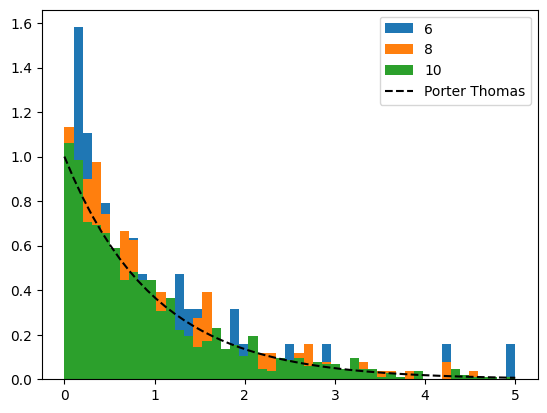

In [3]:
from tools import random_circuit

for nqbits in [6, 8, 10]:

    circ = random_circuit(nqbits, 6)
    qpu = StateVectorQPU(nqbits)
    res2 = qpu.submit(circ)

    data = abs(res2.to_vec())**2 # the probabilities
    probs = np.linspace(0, 5, 50)

    # multiply by 2^n to have more probabilities close to 1
    plt.hist(data*(2**nqbits), bins=probs, label=nqbits, density=True)

plt.plot(probs, np.exp(- probs), '--k', label = "Porter Thomas")

plt.legend();

## Going further

- implement controlled gates
- implement a quantum Fourier transform (using a recursive method)
- implement the measurement of an observable $H$ decomposed on the Pauli basis, $H = \sum_i \lambda_i P_i$.